# Selecting lags on a real world example using feature selection & modelling

In this notebook we shall show how we can use **feature selection & modelling** to decide which lags we could use for forecasting.

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

## Data Set Synopsis

The dataset was collected between January 2004 and March 2005.

It consists of hourly measurements of the different air pollutants: NO2, NOX, CO, C6H6, O3 and NMHC. The measurements are accompanied by local temperature and humidity values, also recorded hourly.

In the data collection experiments, scientists were testing new pollutant sensors. The values from the new sensors are stored in the variables called "_sensors". 

For comparison, data for the pollutants was also gathered from fixed stations that regularly measure the concentration of these gases. Those values are stored in the variables called "_true".

## Challenge

This dataset is particularly challenging because it does not have equidistant timestamps. The timestamps should be equidistant because the scientists aimed to have a pollutant record for each hour. But in practice, we have entire days of recordings missing, probably due to data collection failure.

In [73]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context("talk")

# Load data

In [74]:
filename = "../datasets/AirQualityUCI_ready.csv"
data = pd.read_csv(filename, parse_dates=["Date_Time"], index_col=["Date_Time"])

data.sort_index(inplace=True)
data.head()

,CO_true,CO_sensor,NMHC_true,C6H6_true,NMHC_sensor,NOX_true,NOX_sensor,NO2_true,NO2_sensor,O3_sensor,T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-01-04 00:00:00,1.6,1143.0,106.0,6.3,825.0,96.0,986.0,86.0,1477.0,978.0,12.0,61.6,0.8593
2004-01-04 01:00:00,1.2,1044.0,100.0,5.1,770.0,85.0,1031.0,70.0,1425.0,944.0,11.5,63.9,0.8652
2004-01-04 02:00:00,1.1,1034.0,71.0,4.1,716.0,50.0,1085.0,55.0,1405.0,891.0,10.7,67.2,0.8630
2004-01-04 03:00:00,0.9,956.0,72.0,4.0,713.0,-200.0,1099.0,-200.0,1422.0,849.0,9.0,73.1,0.8394
2004-01-04 04:00:00,0.7,909.0,44.0,2.4,615.0,57.0,1237.0,49.0,1322.0,790.0,10.2,66.6,0.8299


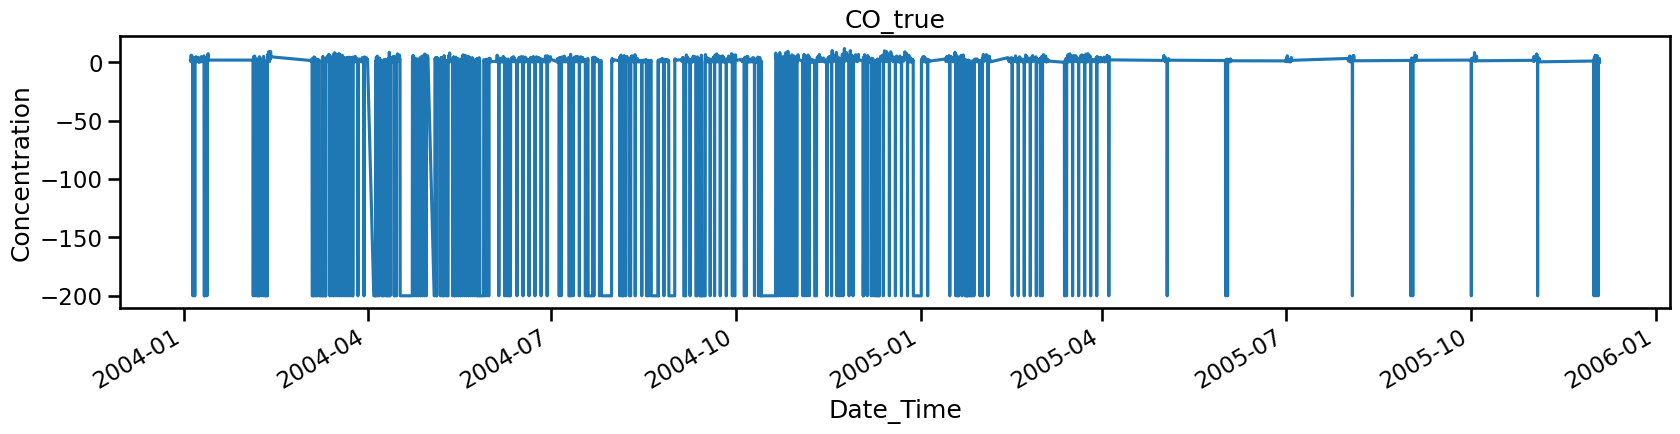

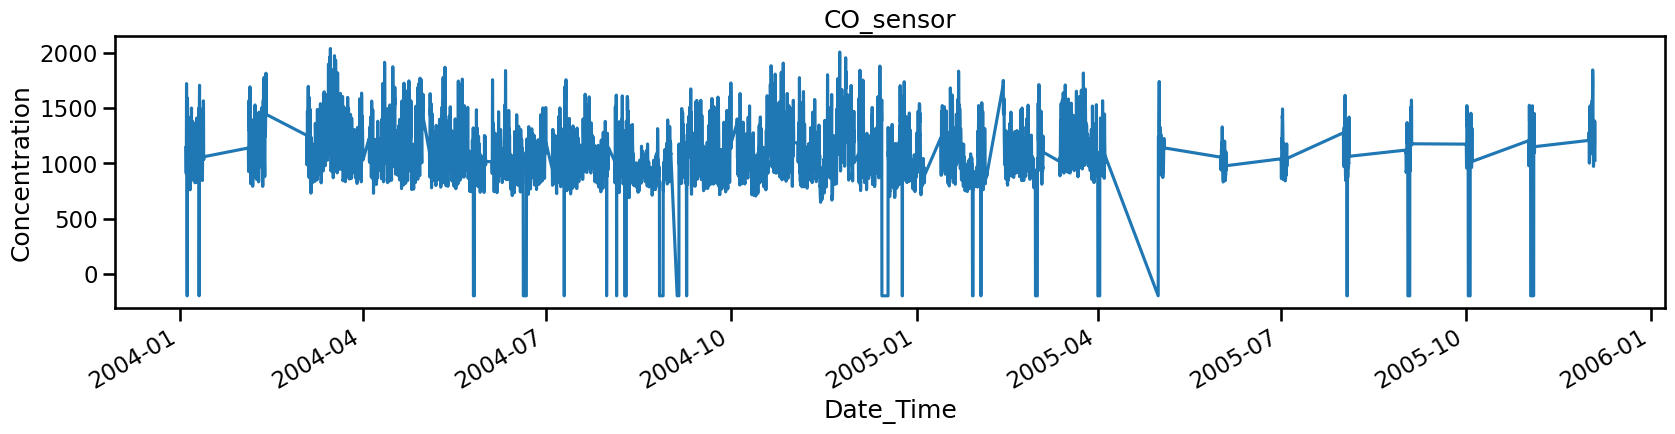

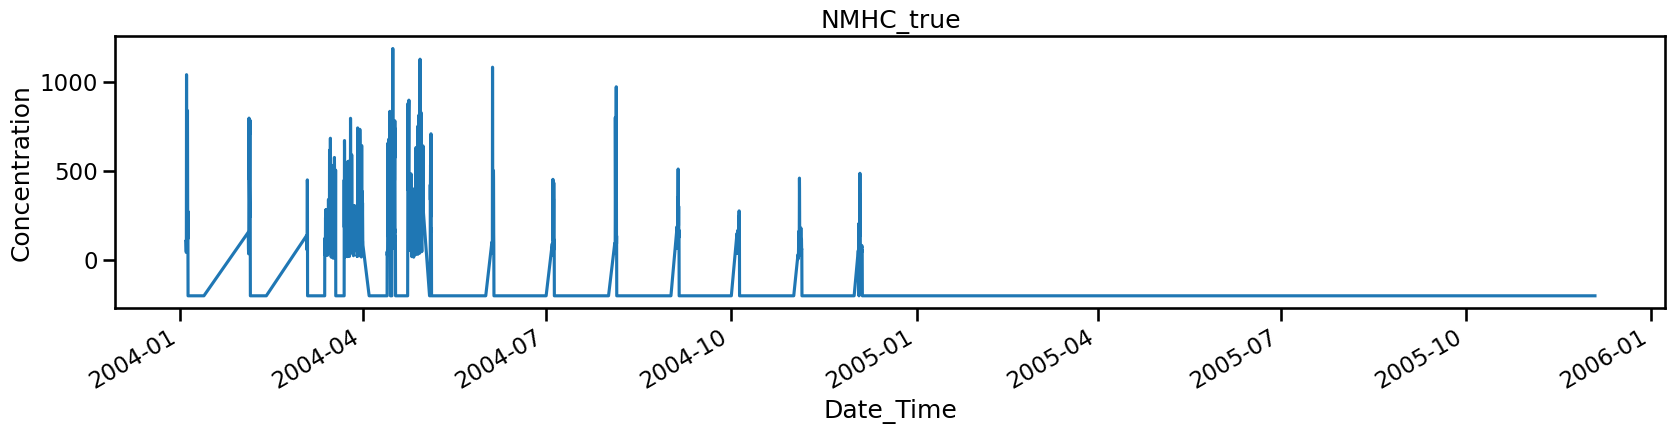

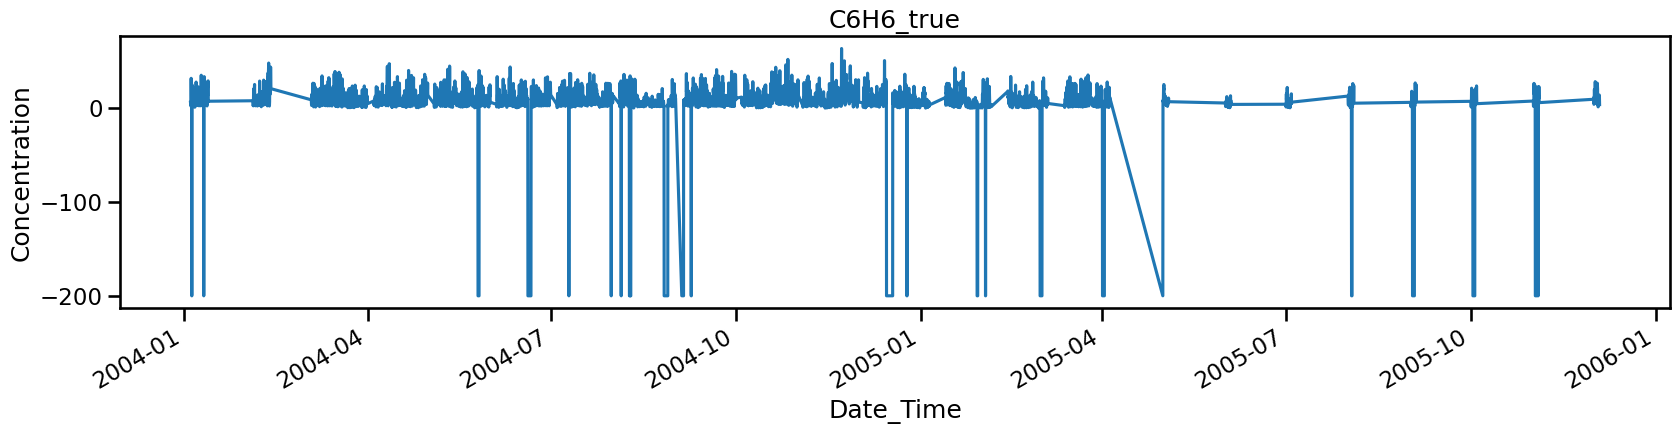

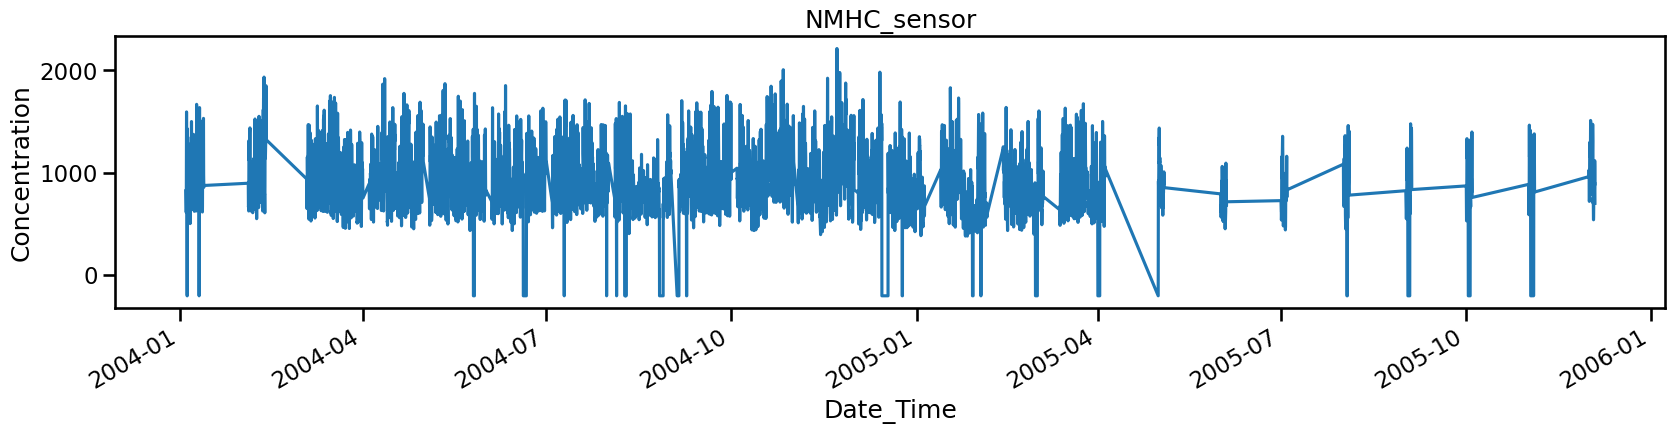

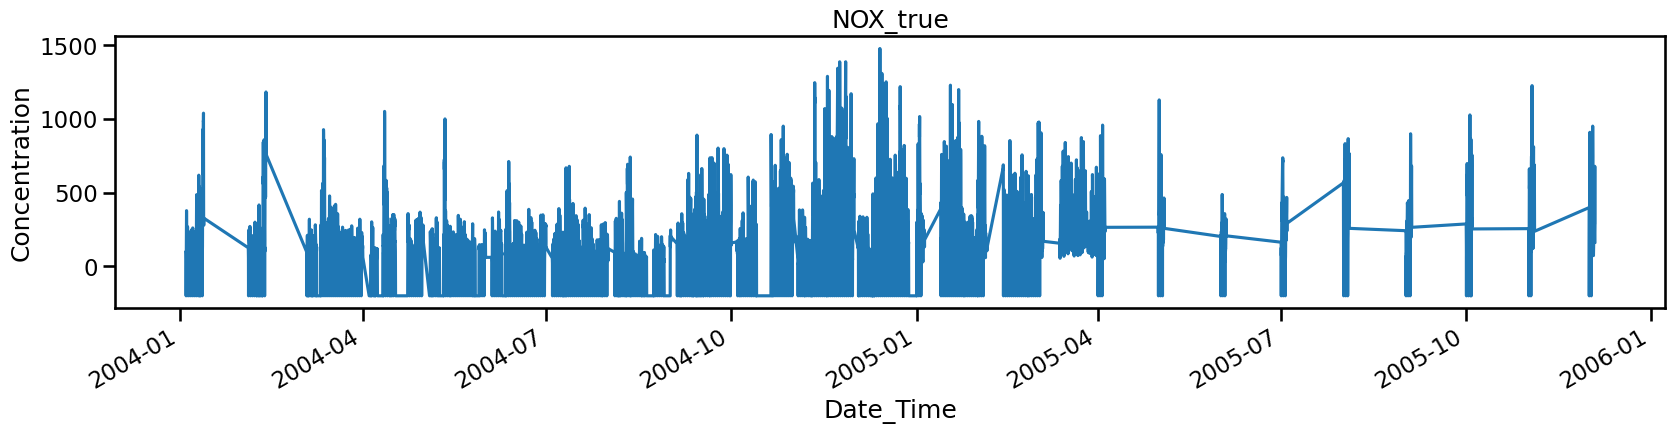

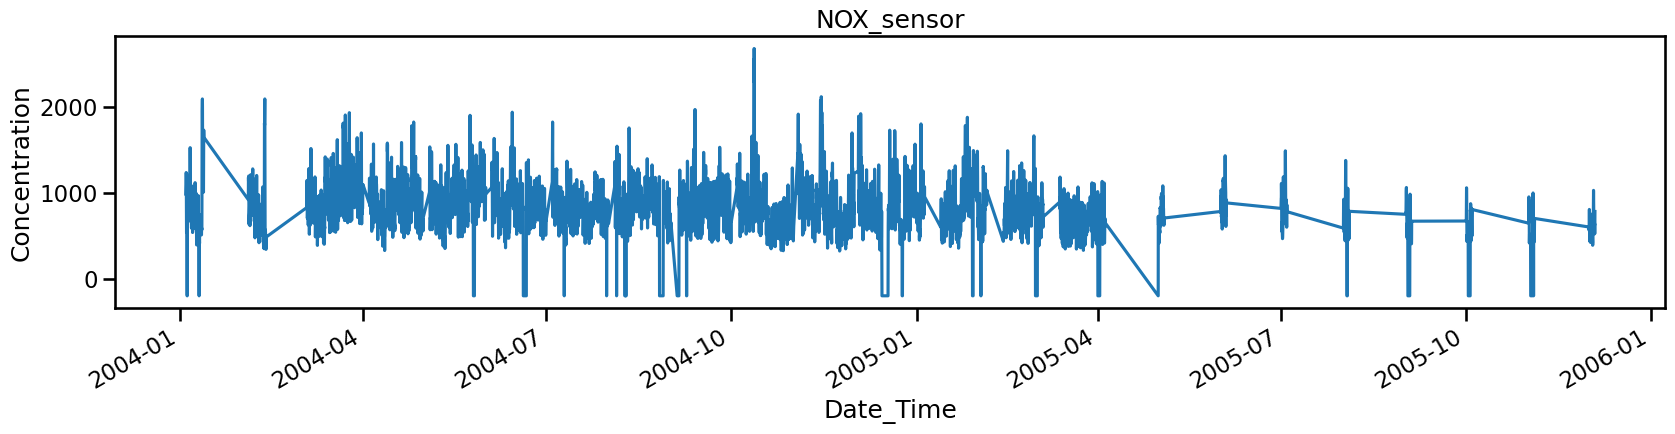

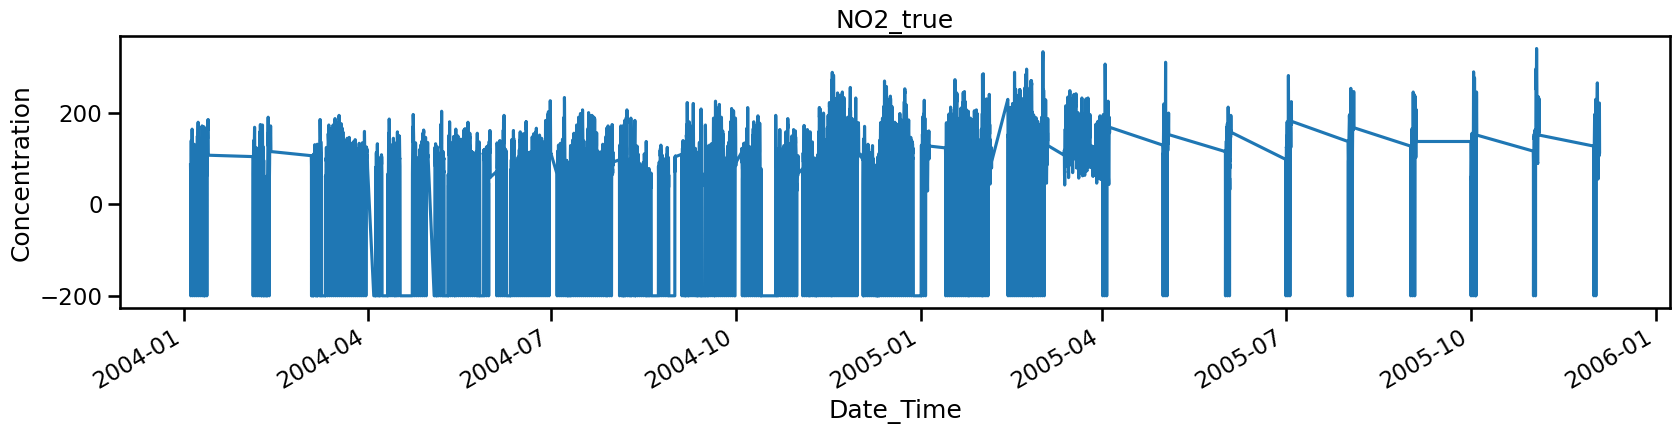

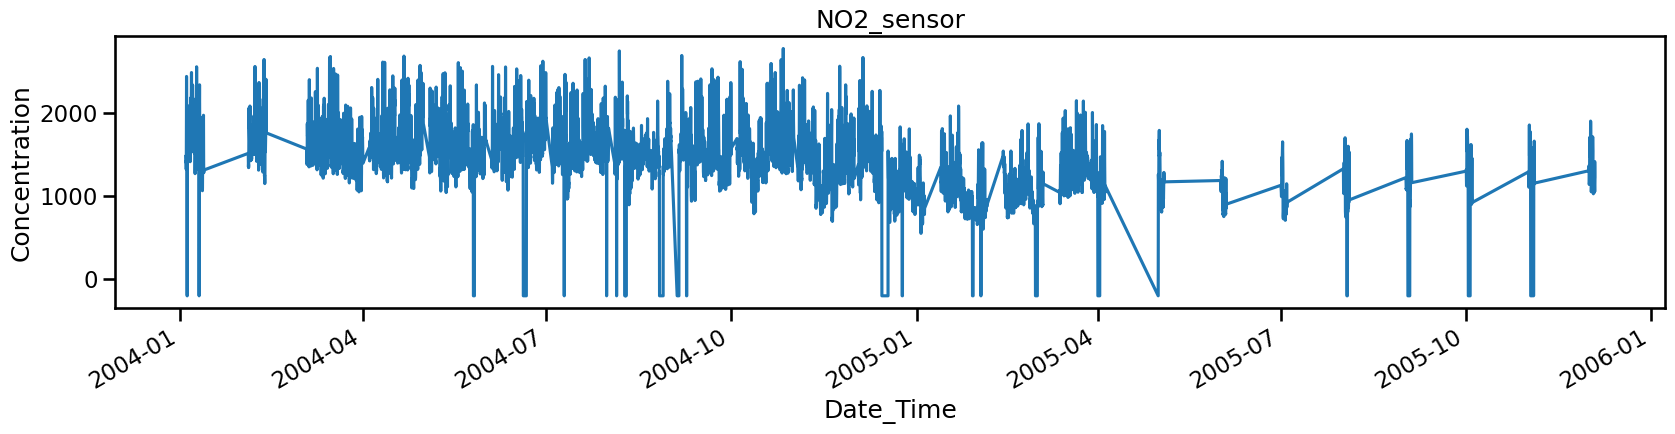

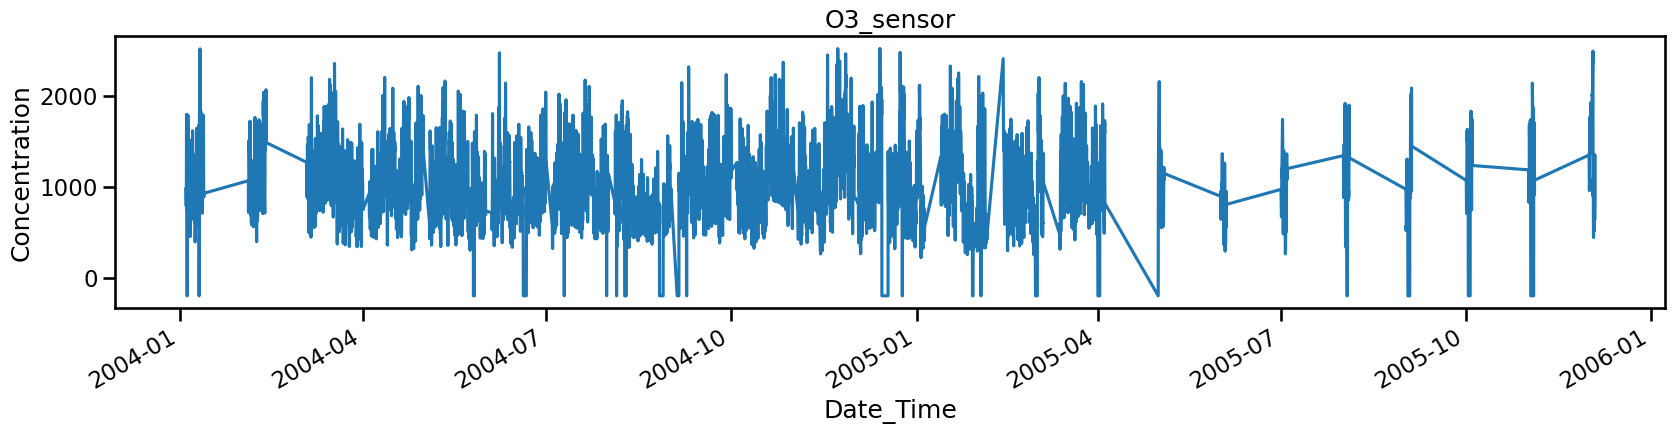

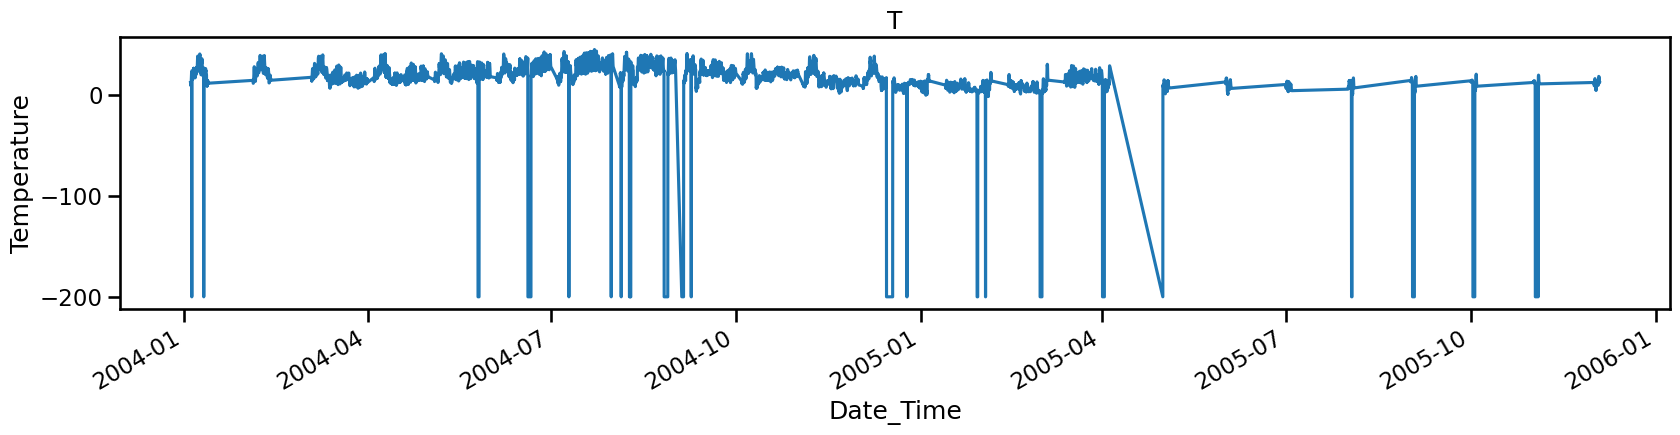

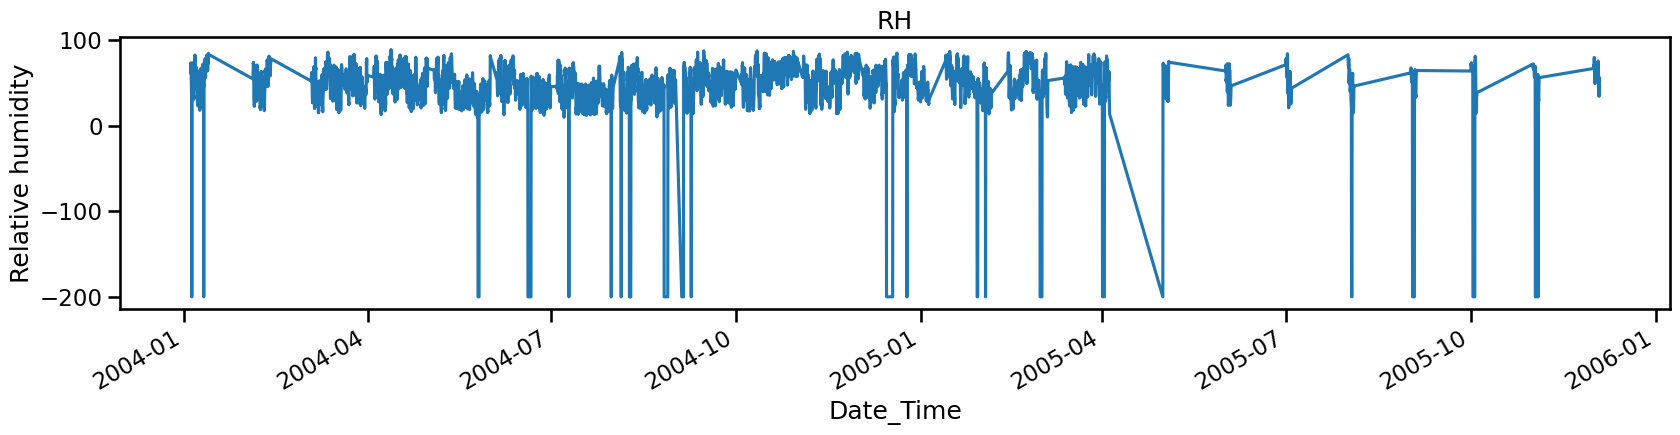

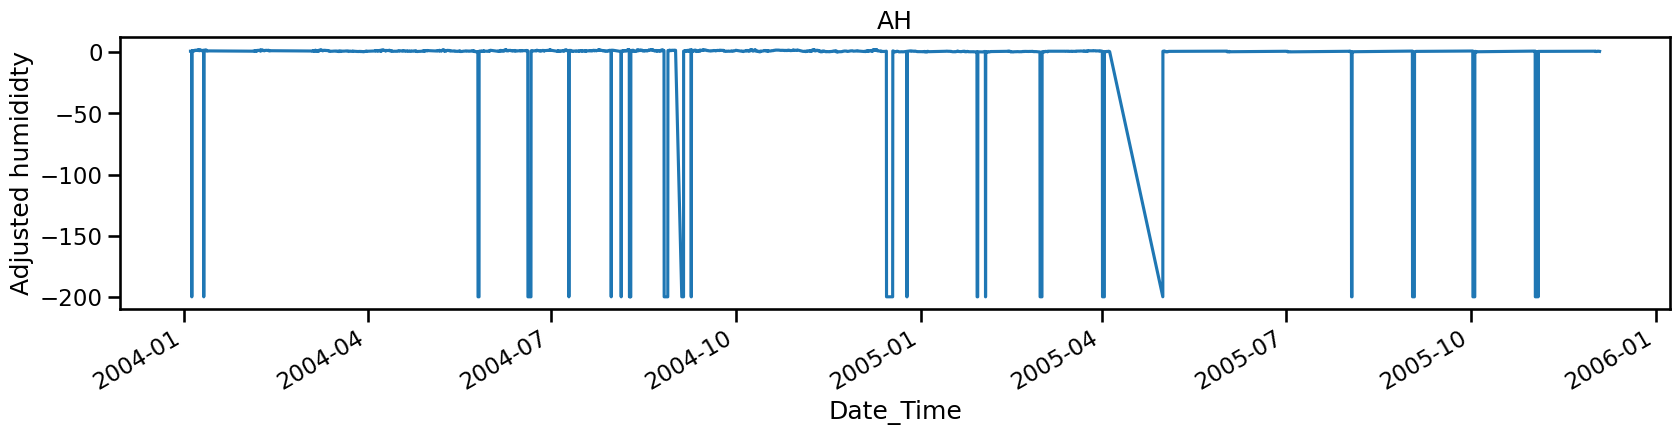

In [75]:
# Plot the time series.
col_by_ylabel = {
    "T": "Temperature",
    "RH": "Relative humidity",
    "AH": "Adjusted humididty",
}

for var in data.columns:
    data[var].plot(figsize=(20, 4))
    plt.title(var)
    ylabel = col_by_ylabel.get(var)
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel("Concentration")
    plt.show()

See the analysis in section 2 notebook 2. Due to data quality issues we will for this demo:

- reduce the data to the span between March 2004 and April 2005 (best quality).

- resample the time series to ensure that the time between each row is one hour.

- work only with the sensor values.

- remove negative values, that is, remove outliers.




In [76]:
# Reduce the time span.
data = data["2004-04-01":"2005-04-30"]

In [77]:
# Resample freq to be hourly. If there are gaps larger
# than one hour they will be representing as NaNs.
data = data.asfreq("1H")

In [78]:
# Remove measurements from fixed stations.
# We'll only be using sensor data.
drop_vars = [var for var in data.columns if "_true" in var]

# Remove adjusted humidity.
drop_vars.append("AH")

# Remove variables.
data.drop(labels=drop_vars, axis=1, inplace=True)

In [79]:
# Impute negative values with NaNs
data[data < 0] = np.NaN

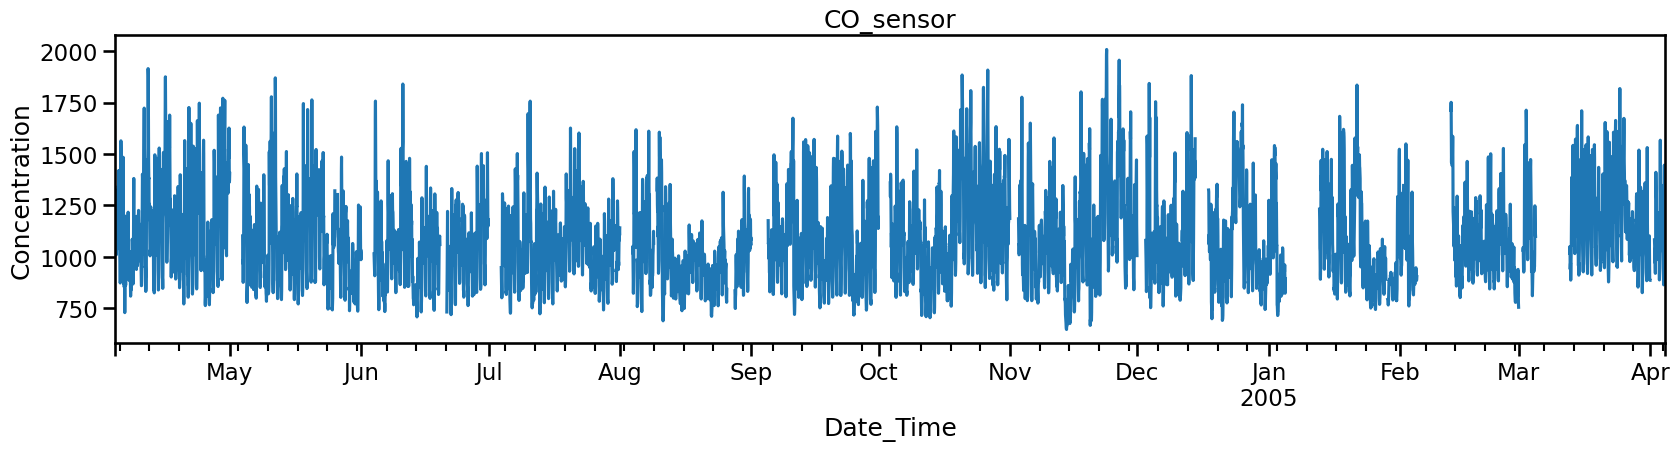

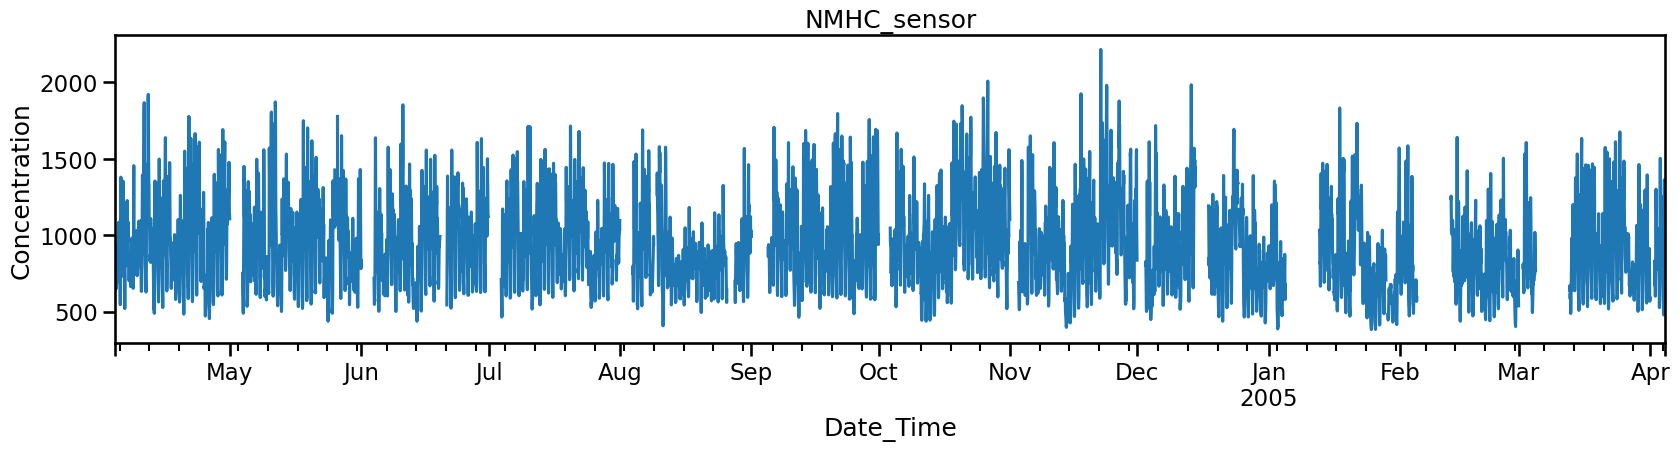

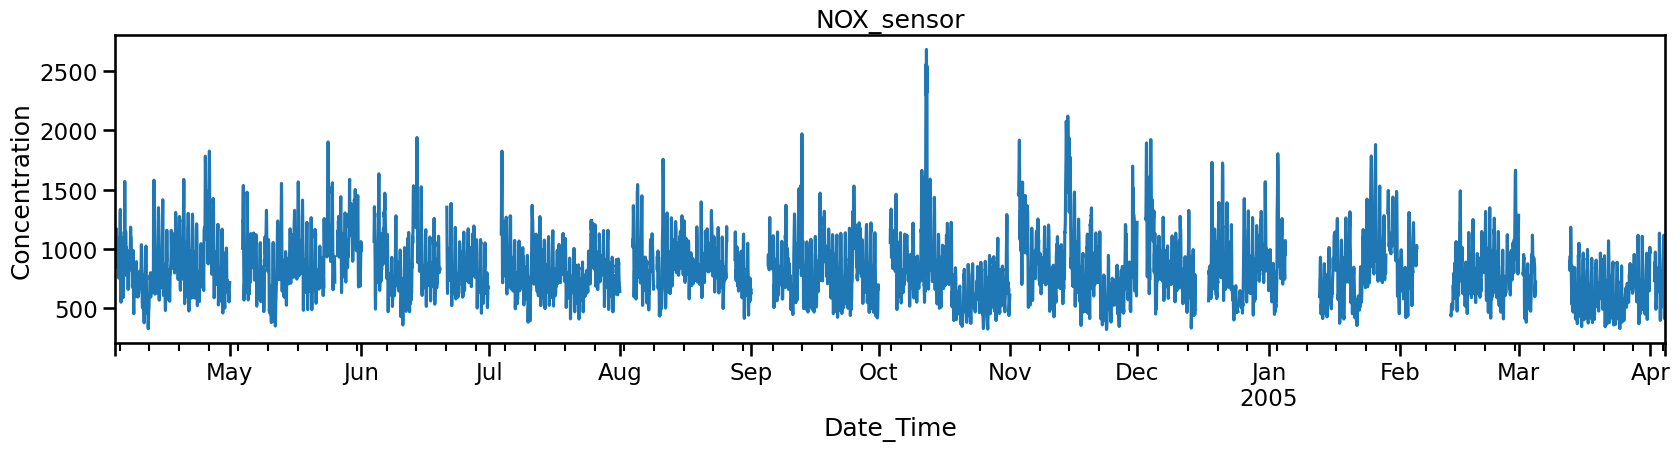

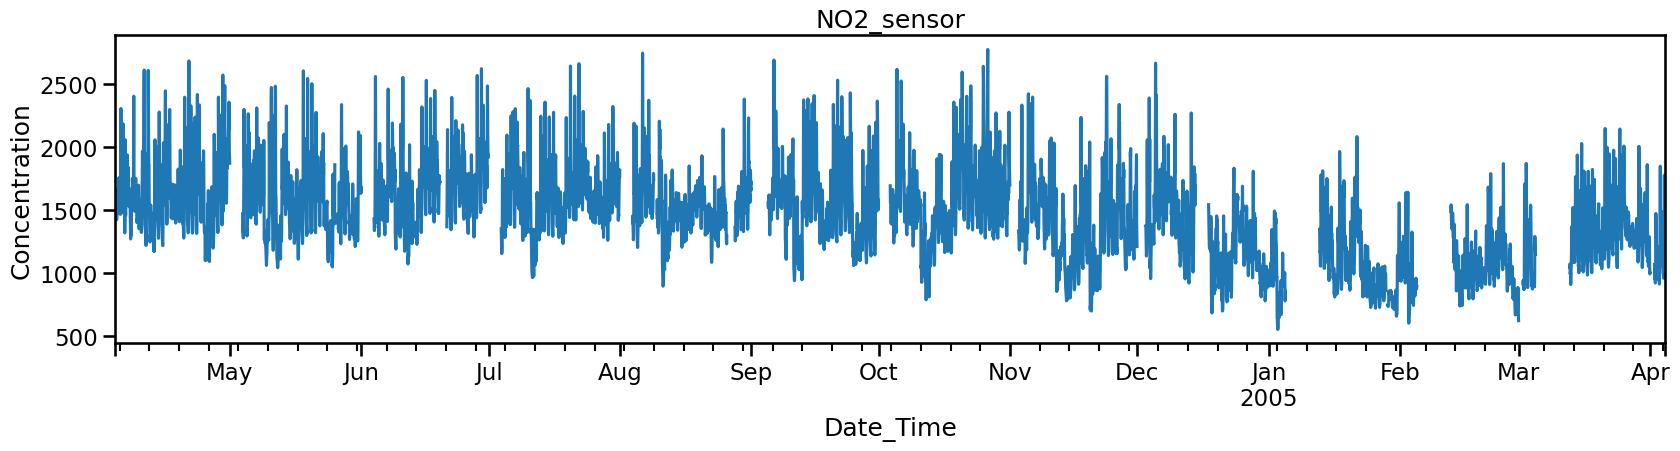

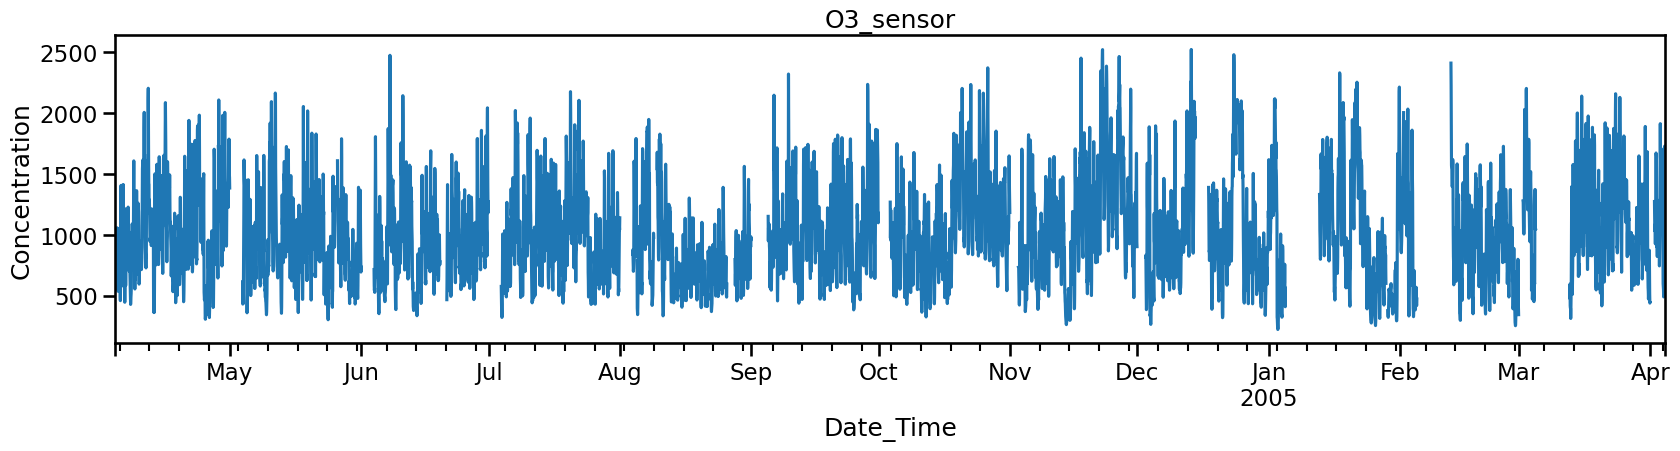

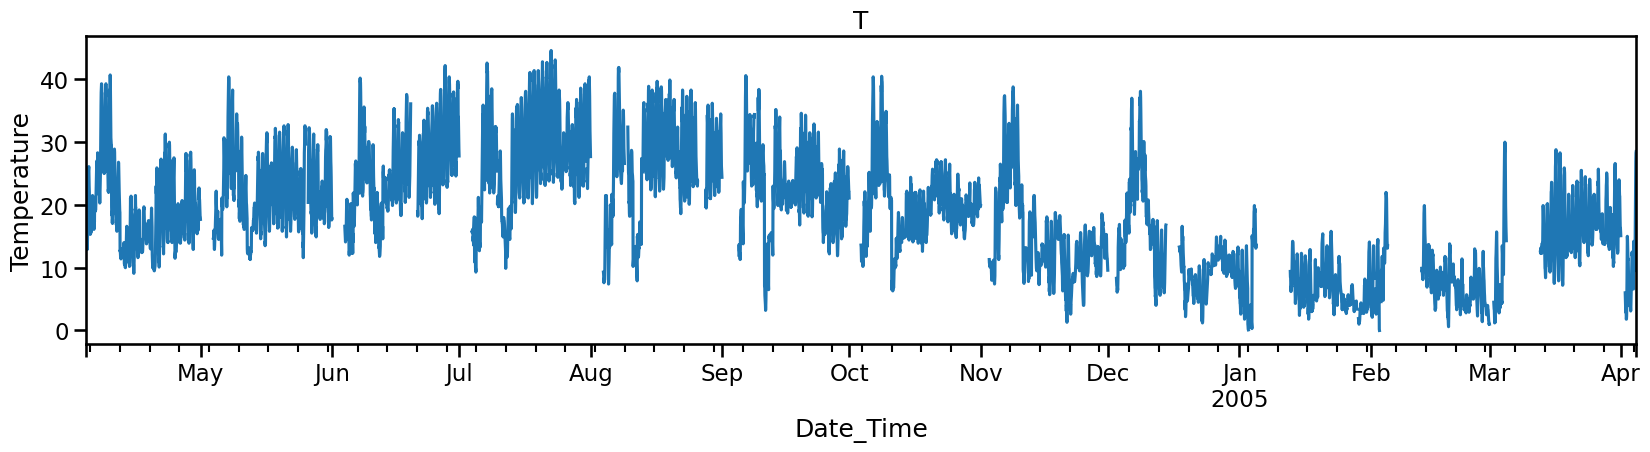

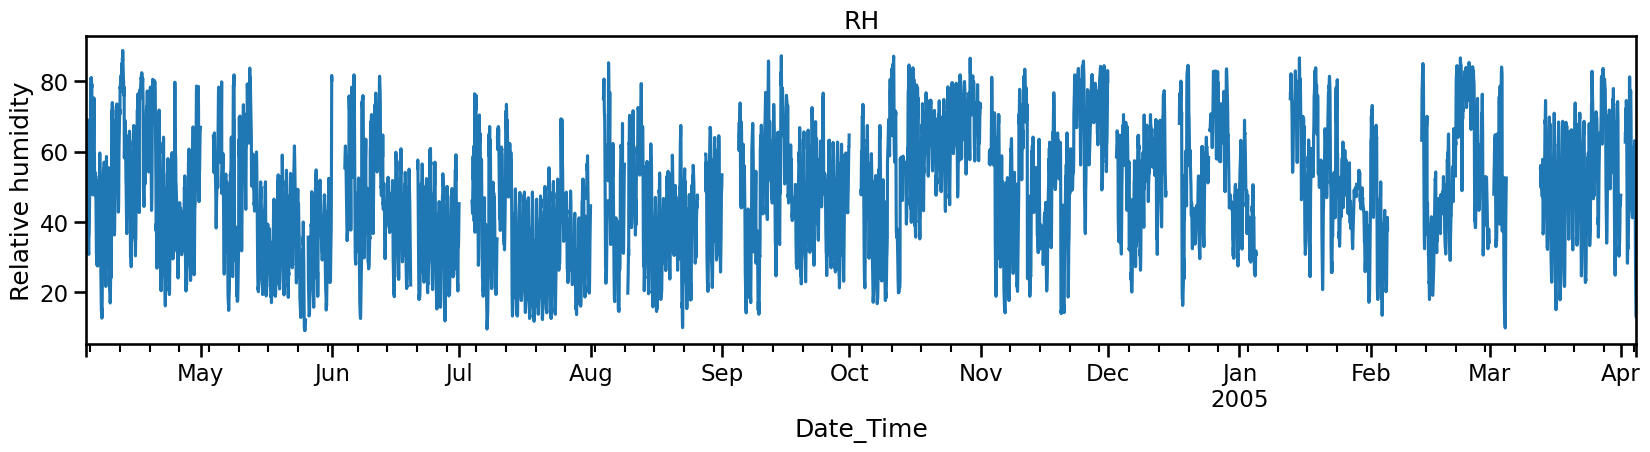

In [80]:
# Plot the time series.
col_by_ylabel = {
    "T": "Temperature",
    "RH": "Relative humidity",
    "AH": "Adjusted humididty",
}

for var in data.columns:
    data[var].plot(figsize=(20, 4))
    plt.title(var)
    ylabel = col_by_ylabel.get(var)
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel("Concentration")
    plt.show()

# Feature selection & modelling

In this section we show how we can use LASSO to determine a small set of features from all the lag features that may be helpful for forecasting. We expect a lot of correlation between the lagged features. For a set of highly correlated features ($x_1$,$x_2$,...,$x_n$) LASSO tends to pick one as important and zero out the others.

In [81]:
from feature_engine.timeseries.forecasting import LagFeatures
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

Let's try to predict NO2 concentrations using historic values for NO2 concentrtions `NO2_sensor` and all the other variables.

In [82]:
target = "NO2_sensor"
raw_features = ["CO_sensor", "NMHC_sensor", "NOX_sensor", "O3_sensor", "T", "RH"]
df = data.copy()

In [83]:
# Fill missing data
df = df.fillna(method="ffill")

Let's create some lagged features. There is one years worth of data. If we use a lag that is very large then that means for data up until that lag we will have missing data for that lagged feature. Therefore we will avoid creating very large lags unless we have good reason to (e.g., yearly seasonality). As we do not have more than one year's worth of data we cannot capture yearly seasonality with a lag feature.

Let's create multiple lags from 1 hour to 1 week ago in hourly increments.

In [84]:
## Create a large number of freqs to lag by
# create range of lags (1h to one week)
freqs = [f"{i}H" for i in range(1, 24 * 7)]
print(freqs)

['1H', '2H', '3H', '4H', '5H', '6H', '7H', '8H', '9H', '10H', '11H', '12H', '13H', '14H', '15H', '16H', '17H', '18H', '19H', '20H', '21H', '22H', '23H', '24H', '25H', '26H', '27H', '28H', '29H', '30H', '31H', '32H', '33H', '34H', '35H', '36H', '37H', '38H', '39H', '40H', '41H', '42H', '43H', '44H', '45H', '46H', '47H', '48H', '49H', '50H', '51H', '52H', '53H', '54H', '55H', '56H', '57H', '58H', '59H', '60H', '61H', '62H', '63H', '64H', '65H', '66H', '67H', '68H', '69H', '70H', '71H', '72H', '73H', '74H', '75H', '76H', '77H', '78H', '79H', '80H', '81H', '82H', '83H', '84H', '85H', '86H', '87H', '88H', '89H', '90H', '91H', '92H', '93H', '94H', '95H', '96H', '97H', '98H', '99H', '100H', '101H', '102H', '103H', '104H', '105H', '106H', '107H', '108H', '109H', '110H', '111H', '112H', '113H', '114H', '115H', '116H', '117H', '118H', '119H', '120H', '121H', '122H', '123H', '124H', '125H', '126H', '127H', '128H', '129H', '130H', '131H', '132H', '133H', '134H', '135H', '136H', '137H', '138H', '13

In [85]:
## Create lag features for all the raw features and the target

# all the feature that I want to apply the lags
features_to_lag = raw_features.append(target)

# create the lags on the features  
lag = LagFeatures(variables=features_to_lag, freq=freqs)

# fit that
df = lag.fit_transform(df)

# drop NaNs introduced by lagging
df = df.dropna() 

df.head()

,CO_sensor,NMHC_sensor,NOX_sensor,NO2_sensor,O3_sensor,T,RH,CO_sensor_lag_1H,NMHC_sensor_lag_1H,NOX_sensor_lag_1H,...,O3_sensor_lag_166H,T_lag_166H,RH_lag_166H,CO_sensor_lag_167H,NMHC_sensor_lag_167H,NOX_sensor_lag_167H,NO2_sensor_lag_167H,O3_sensor_lag_167H,T_lag_167H,RH_lag_167H
Date_Time,,,,,,,,,,,,,,,,,,,,,
2004-04-10 23:00:00,1011.0,875.0,787.0,1446.0,1012.0,20.6,60.9,1039.0,936.0,731.0,...,862.0,15.9,59.2,1224.0,892.0,884.0,1580.0,923.0,16.7,56.5
2004-04-11 00:00:00,1043.0,975.0,675.0,1489.0,1041.0,18.7,69.0,1011.0,875.0,787.0,...,752.0,15.2,62.4,1215.0,843.0,929.0,1551.0,862.0,15.9,59.2
2004-04-11 01:00:00,948.0,826.0,802.0,1382.0,897.0,19.3,65.5,1043.0,975.0,675.0,...,791.0,14.7,65.0,1115.0,782.0,980.0,1500.0,752.0,15.2,62.4
2004-04-11 02:00:00,955.0,775.0,831.0,1362.0,862.0,17.6,70.8,948.0,826.0,802.0,...,697.0,14.3,65.3,1124.0,793.0,965.0,1521.0,791.0,14.7,65.0
2004-04-11 03:00:00,915.0,721.0,891.0,1315.0,816.0,16.8,72.9,955.0,775.0,831.0,...,664.0,13.7,66.5,1028.0,682.0,1090.0,1448.0,697.0,14.3,65.3


In [86]:
# We will only use lag features to avoid data leakage
features = [col for col in df.columns if "lag" in col]
print(f"Number of features {len(features)}")

Number of features 1169


In [87]:
# Create the data matrix and target variable
# We standardise the features and target so
# we can use LASSO for feature selection

y = df[[target]] # waht we want to predict 

# y = StandardScaler().fit_transform(df[target].to_frame())
X = StandardScaler().fit_transform(df[features]) # the feature foe predict the target

<Axes: >

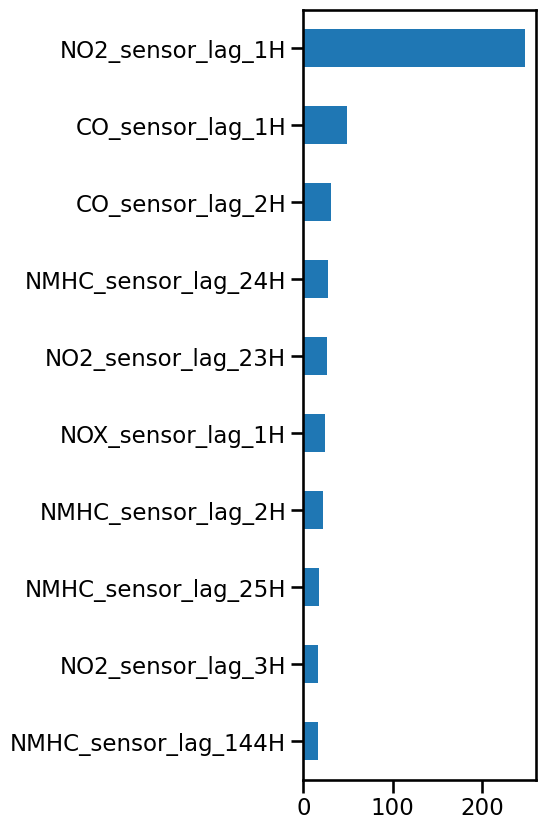

In [88]:
## Now let's use LASSO

# create an instance of the Lasso model 
model = Lasso(alpha=1)

# train the model
model.fit(X, y)

# extract the importence feature 
feat_importances = pd.Series(index=features, data=model.coef_)

# plot the top 10 most importent features 
feat_importances.abs().nlargest(10).iloc[::-1].plot(kind="barh", figsize=(3, 10))

We see that `alpha=1` is too high and forces all features to zero. Let's try a couple of smaller values.

<Axes: >

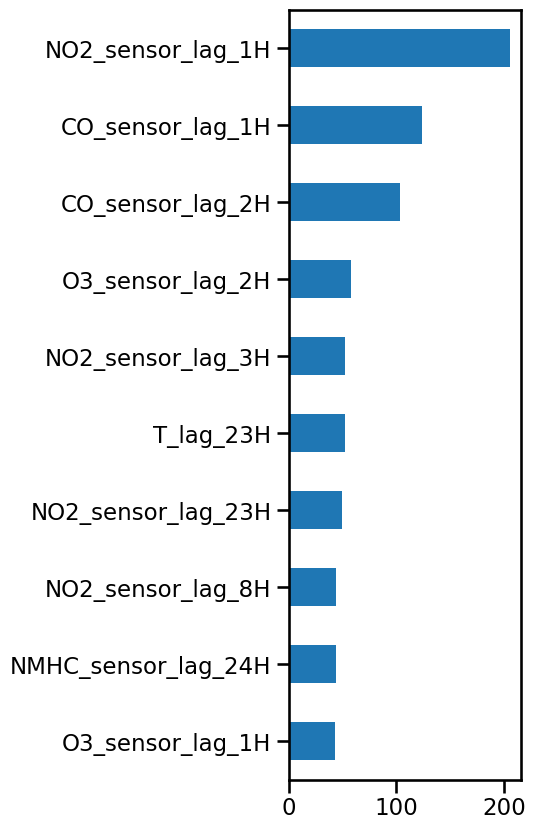

In [89]:
# Now let's use LASSO
model = Lasso(alpha=0.1)
model.fit(X, y)
feat_importances = pd.Series(index=features, data=model.coef_)
feat_importances.abs().nlargest(10).iloc[::-1].plot(kind="barh", figsize=(3, 10))

At `alpha=0.1` we see that LASSO picks up lag values of the target as being important. The last 1 hour and also seasonalities (i.e., 23 hours ago is approximately one day and 167 hours ago is approximately 1 week) are identified as important lags!

c:\Users\97250\Desktop\sample_project_1\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.715e+06, tolerance: 1.104e+05
  model = cd_fast.enet_coordinate_descent(


<Axes: >

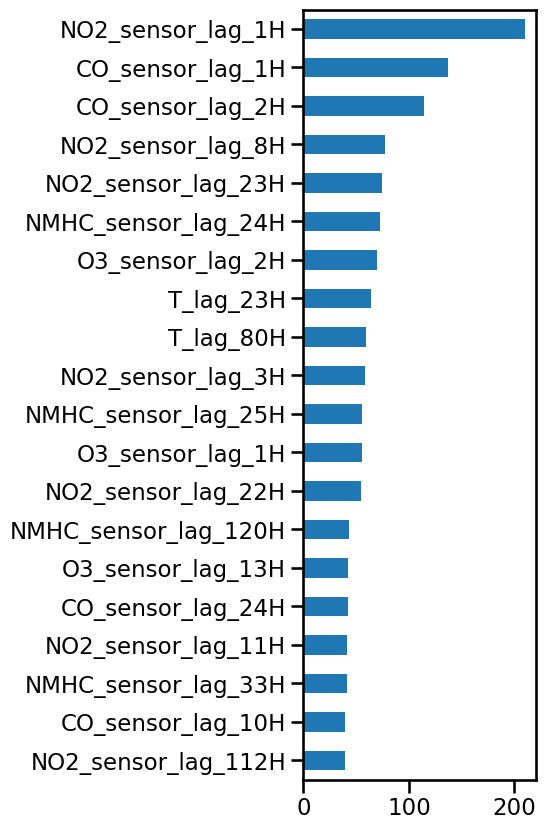

In [90]:
# Now let's use LASSO
model = Lasso(alpha=0.01)
model.fit(X, y)
feat_importances = pd.Series(index=features, data=model.coef_)
feat_importances.abs().nlargest(20).iloc[::-1].plot(kind="barh", figsize=(3, 10))

At `alpha=0.01` (so a lot less regularised) we see that LASSO picks up lag values of the target and some other features as being important. We see a range of lags but mostly those which are recent (e.g., 1 or 2 hours), daily seasonality (e.g., approximately 24 hours), and weekly seasonlity (e.g., close to 168 hours). 

This allows us to go from 1169 features from a large range of lags down to a much smaller set of lags. What is great is that LASSO is able to pick up the recent and seasonal lags all on its own without us having to do much!

We now have a set of lagged features that we can use to build a forecasting model and evaluate using backtesting. 